## Credit Default

**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import missingno as msno

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [8]:
DATA_ROOT = Path('./data/project/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'project_data.csv'
TEST_DATASET_PATH = DATA_ROOT / 'project_data_test.csv'

PREP_DATASET_PATH = DATA_ROOT / 'project_data_prep.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'project_train_full.csv'
TEST_FULL_PATH = DATA_ROOT / 'project_test_full.csv'
PREDICTION_PATH = DATA_ROOT / 'sample_submission.csv'

TRAIN_PART_PATH = DATA_ROOT / 'project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

### Загрузка и подготовка данных

**Описание базового датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Загрузка данных**

In [9]:
df_base = pd.read_csv(DATASET_PATH)
df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
df_base.shape

(7500, 17)

In [11]:
df_base.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [12]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Обзор целевой переменной**

In [13]:
df_base['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [14]:
df_base.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор категориальных признаков**

In [15]:
for cat_colname in df_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Пропуски**

In [16]:
df_base.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

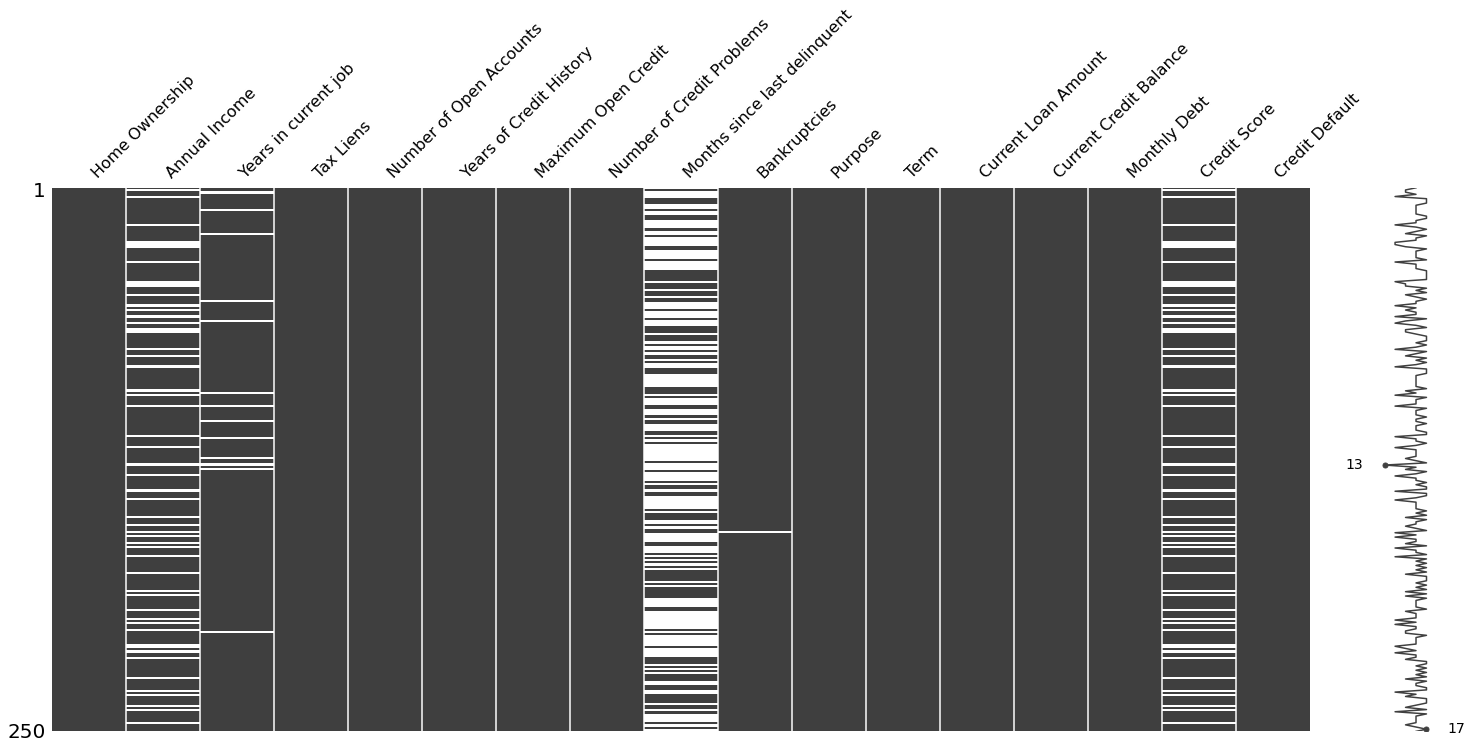

In [17]:
msno.matrix(df_base.sample(250));

**Подготовка данных**

In [18]:
class DataPreparation:
    def __init__(self, path_to_file):
        self.current_loan_amount_median = 0
        self.add_dummies_columns = None
        self.df = pd.read_csv(path_to_file)
        
    def get_loan_amount_median(self):
        return self.df[self.df['Current Loan Amount'] <= 9999999.0]['Current Loan Amount'].mean()
    
    def get_default_annual_income(self):
        a_i = self.df[self.df['Annual Income'] != 0]['Annual Income']
        return (2 * a_i.mean() + 3 * a_i.min())/5
    
    def transform(self, current_loan_amount_median, default_annual_income):
        df = self.df.copy()
        add_dummies_columns = None

        YICJ_to_numbers = {'< 1 year':'0',
                            '1 year':'1','2 years':'1','3 years':'1','4 years':'1','5 years':'2', 
                            '6 years':'2','7 years':'2','8 years':'3','9 years':'3',
                            '10+ years':'3'}

        df.loc[df['Purpose'] == 'buy a car', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'buy house', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'home improvements', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
        
        df.loc[df['Annual Income'] == 0, 'Current Loan Amount'] = default_annual_income
        
        df.loc[df['Credit Score'] >= 3000, 'Credit Score'] = (df['Credit Score'] / 10)
    
        #df['TooBigLoanAmount'] = 1 * (df['Current Loan Amount'] > 9999999.0)
        #df.loc[df['Current Loan Amount'] >= 9999999.0, 'Current Loan Amount'] = current_loan_amount_median
    
    
        df['Annual Income'].fillna(0.0, inplace=True)
        df['Home Ownership'].fillna('Rent', inplace=True)
        df['Years in current job'].fillna('3 years', inplace=True)
        df['Bankruptcies'].fillna(0.0, inplace=True)
        df['Months since last delinquent'].fillna(0.0, inplace=True)
        df['Credit Score'].fillna(1000.0, inplace=True)
        
        df.loc[df['Bankruptcies'] >= 3, 'Bankruptcies'] = 3
        
        #Bankruptcies_to_cat = {0:'A',1:'B',2:'C',3:'D'}
        #df['Bankruptcies'] = df['Bankruptcies'].map(Bankruptcies_to_cat)

        df['Years in current job'] = df['Years in current job'].map(YICJ_to_numbers)

        #df = pd.get_dummies(df, columns = ['Home Ownership','Purpose'])
        #df = pd.get_dummies(df, columns = ['Term','Years in current job'])
        
        return df

In [19]:
train_data_preparation = DataPreparation(DATASET_PATH)
current_loan_amount_median = train_data_preparation.get_loan_amount_median()
default_annual_income = train_data_preparation.get_default_annual_income()
train_df = train_data_preparation.transform(current_loan_amount_median, default_annual_income)

train_df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

test_data_preparation = DataPreparation(TEST_DATASET_PATH)
test_df = test_data_preparation.transform(current_loan_amount_median, default_annual_income)

In [20]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,1,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,3,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,3,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,2,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,3,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Анализ признакового пространства

In [21]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков

In [22]:
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit',
                     'Number of Credit Problems','Months since last delinquent', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt',
                     'Bankruptcies',
                     #'TooBigLoanAmount',
                    'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose',
                     #'Bankruptcies',
                     'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

**Матрица корреляций**

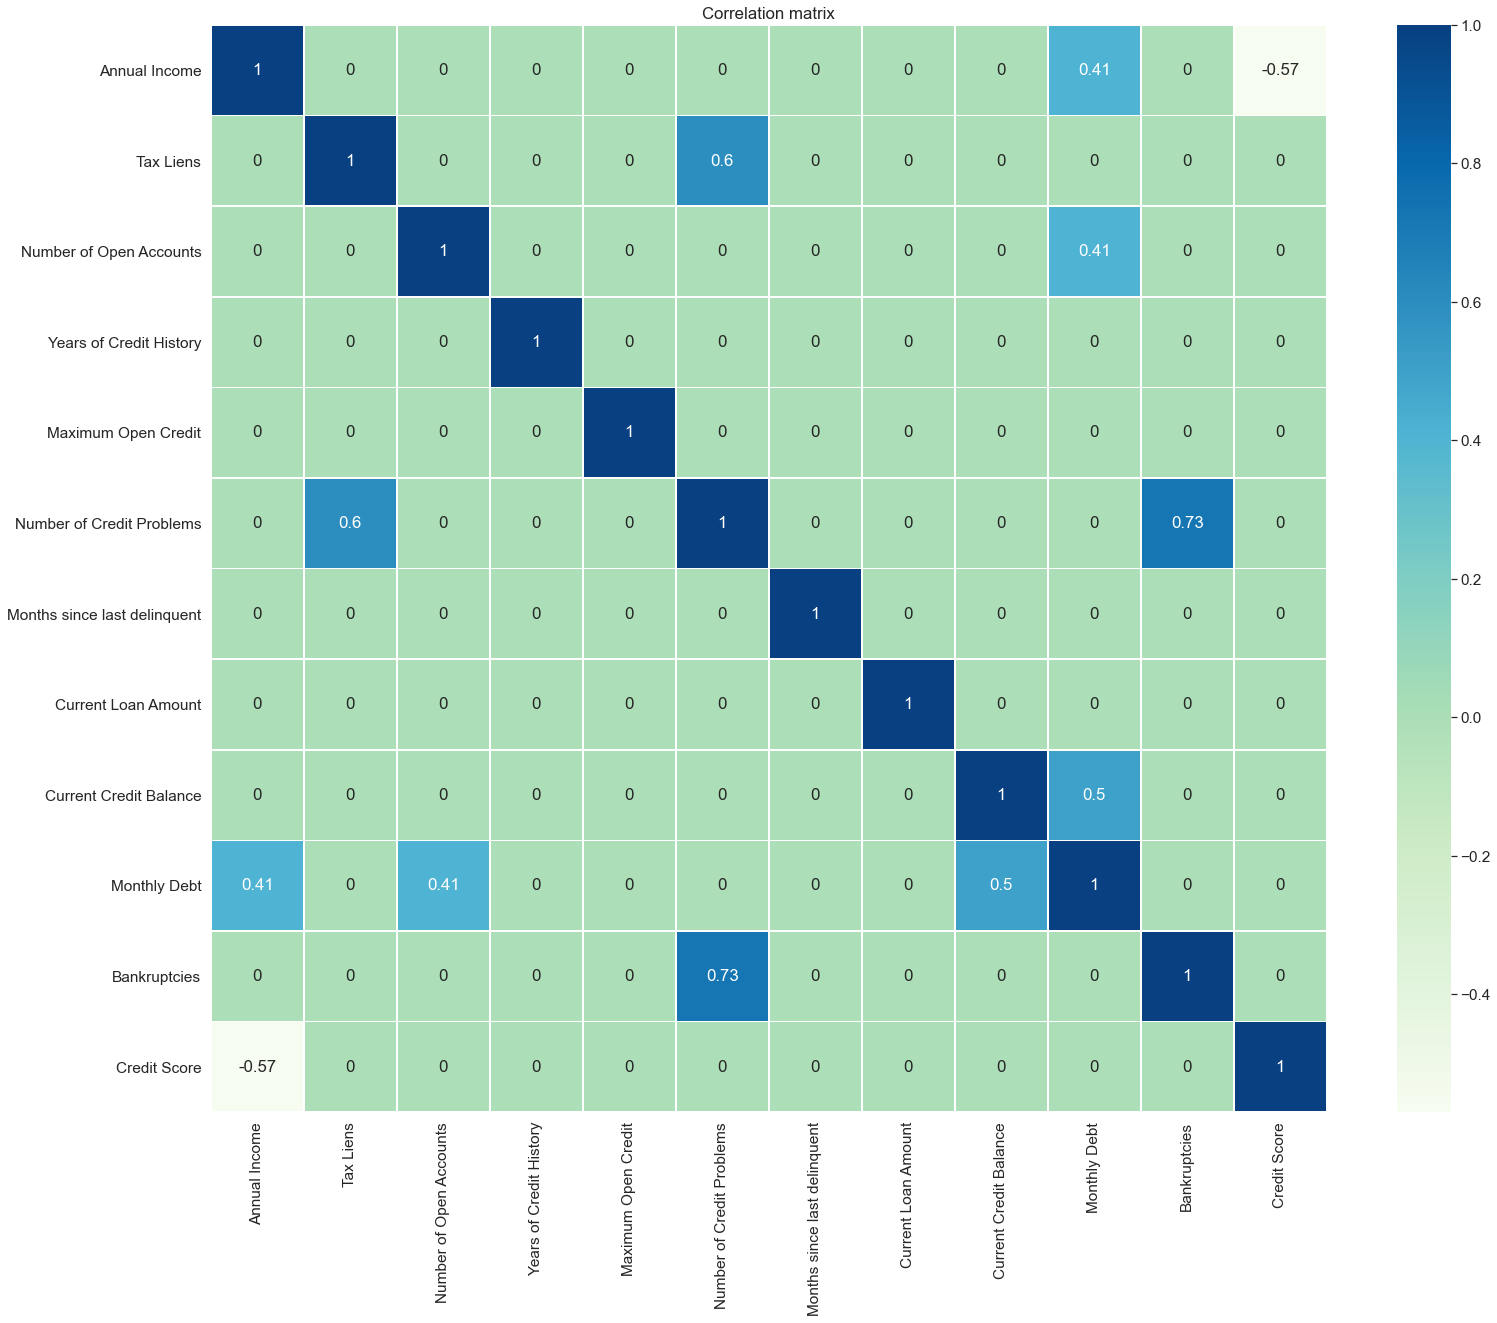

In [23]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = train_df[NUM_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

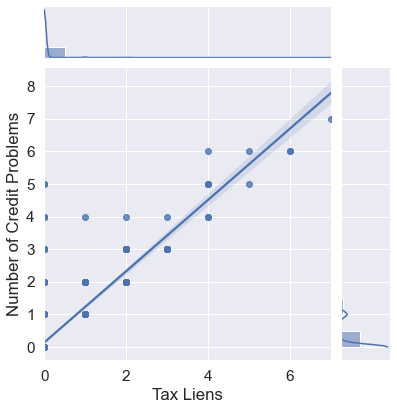

In [24]:
sns.jointplot(train_df['Tax Liens'], train_df['Number of Credit Problems'], kind='reg');

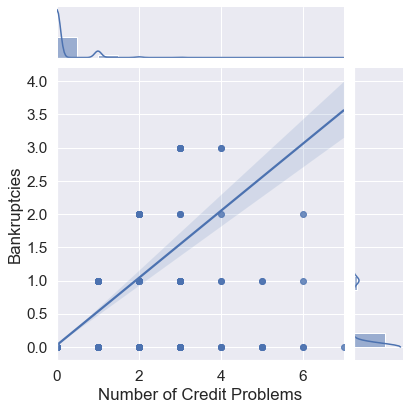

In [25]:
sns.jointplot(train_df['Number of Credit Problems'], train_df['Bankruptcies'], kind='reg');

**Распределения вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9347688.0, pvalue=0.4131472286486712)


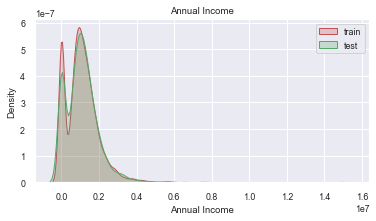

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


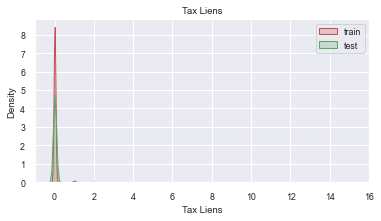

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


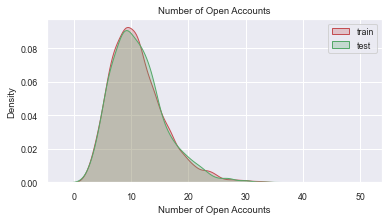

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


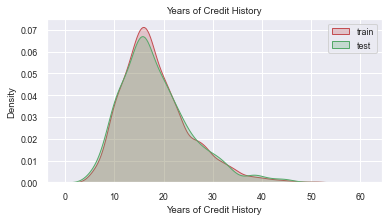

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


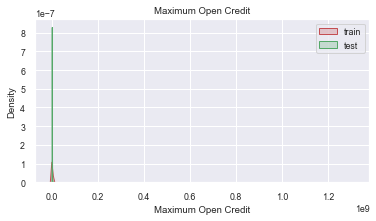

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


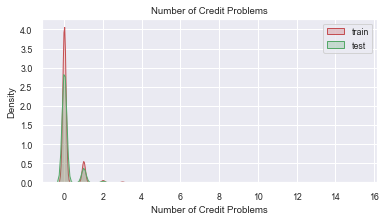

Months since last delinquent
MannwhitneyuResult(statistic=9346198.5, pvalue=0.40057108736095315)


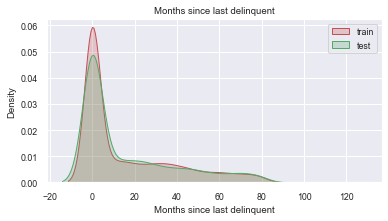

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


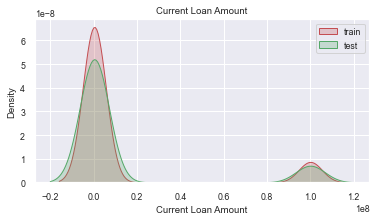

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


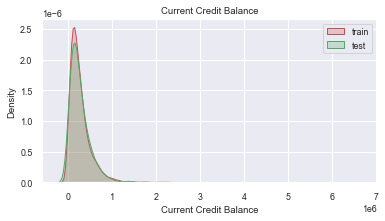

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


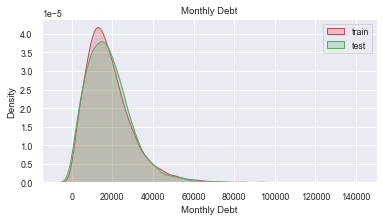

Bankruptcies
MannwhitneyuResult(statistic=9260963.5, pvalue=0.04431622286750682)


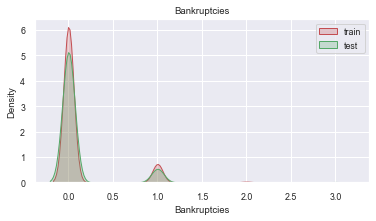

Credit Score
MannwhitneyuResult(statistic=9248855.5, pvalue=0.15536565783598894)


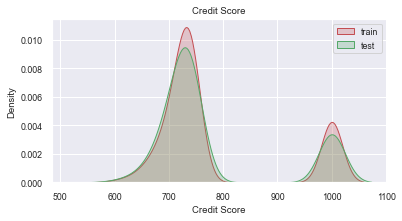

In [26]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

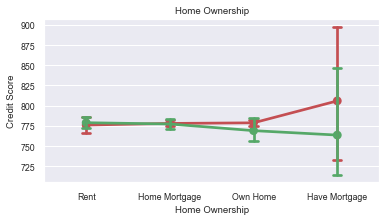

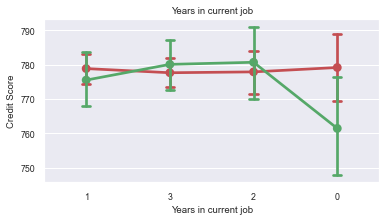

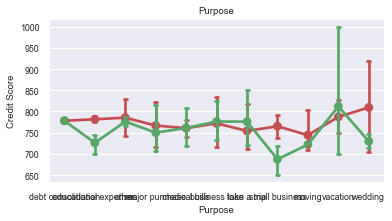

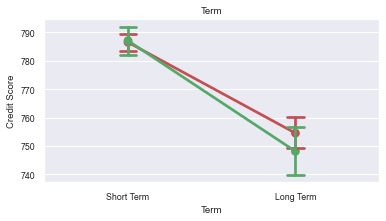

In [27]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

### Масштабрование данных

In [28]:
scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

test_df_norm = test_df.copy()
test_df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(test_df_norm[NUM_FEATURE_NAMES])

test_df =  test_df_norm.copy()

**Сохранение модели для масштабирования данных**

In [29]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Сохранение нормализованных данных**

In [30]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
test_df.to_csv(TEST_FULL_PATH, index=False, encoding='utf-8')

### Заполнение пропусков/выбросов на основе предсказаний

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

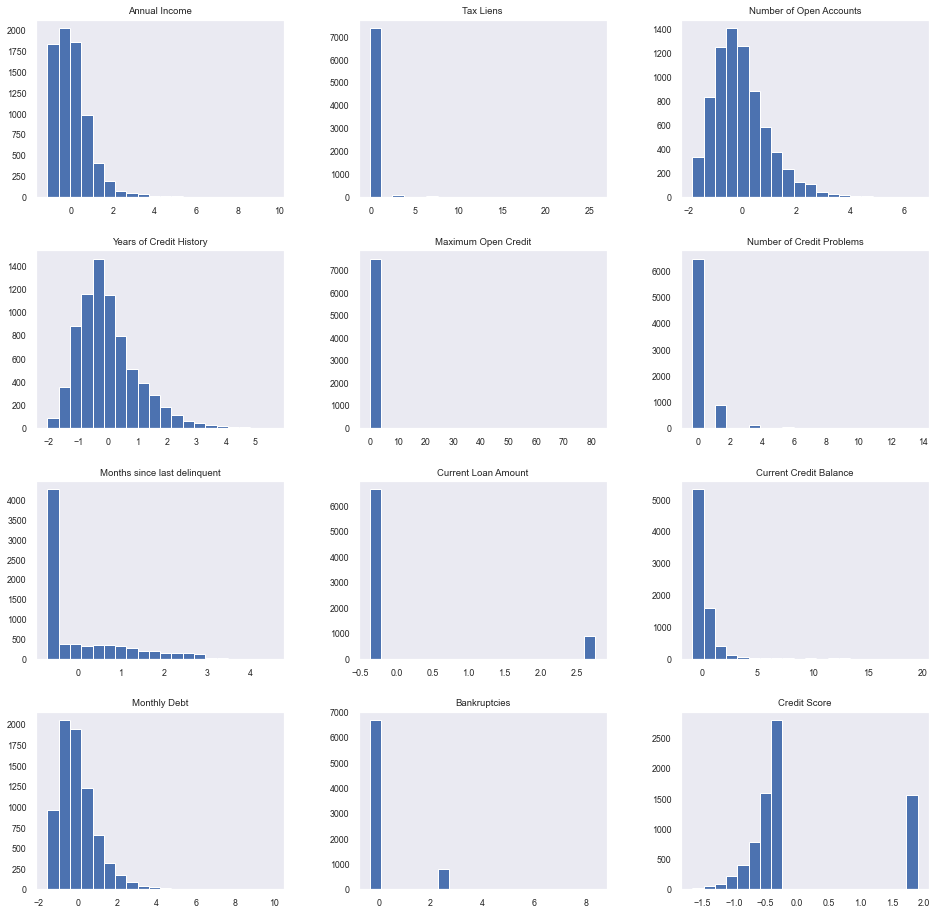

In [32]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [33]:
df_copy = df.copy()
test_df_copy = test_df.copy()

df_copy = pd.get_dummies(df_copy, columns = ['Home Ownership','Purpose'])
df_copy = pd.get_dummies(df_copy, columns = ['Term','Years in current job'])
#df_copy = pd.get_dummies(df_copy, columns = ['Bankruptcies'])

test_df_copy = pd.get_dummies(test_df_copy, columns = ['Home Ownership','Purpose'])
test_df_copy = pd.get_dummies(test_df_copy, columns = ['Term','Years in current job'])
#test_df_copy = pd.get_dummies(test_df_copy, columns = ['Bankruptcies'])

In [34]:
df_copy.isna().sum().sum()

0

In [35]:
test_df_copy.isna().sum().sum()

0

**Annual Income**

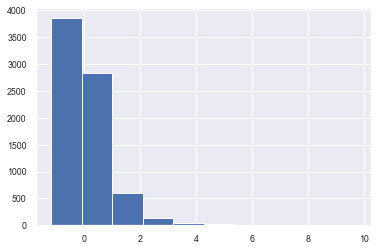

In [36]:
feature_name = 'Annual Income'
df_copy[feature_name].hist();

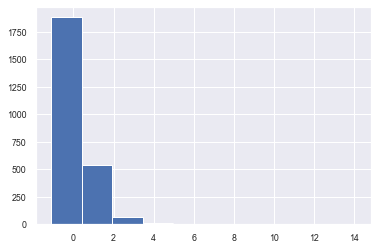

In [37]:
test_df_copy[feature_name].hist();

In [38]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=4)
df_copy[feature_name].isna().sum()

49

In [39]:
test_df_copy = preprocess_outlier(test_df_copy, feature_name, threshold=4)
test_df_copy[feature_name].isna().sum()

14

In [40]:
%%time
bill_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8359191029244857
r2 на test: 0.6872342458714891
Wall time: 3.47 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [41]:
%%time
bill_amt1_predictor, test_df_copy = imputer_rfr(test_df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8802308522826261
r2 на test: 0.6918147417931205
Wall time: 1.15 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [42]:
df_copy[feature_name].isna().sum()

0

In [43]:
test_df_copy[feature_name].isna().sum()

0

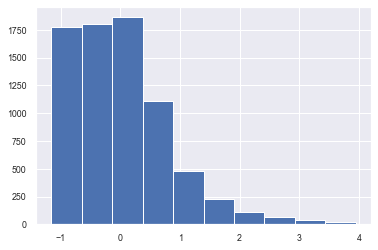

In [44]:
df_copy[feature_name].hist();

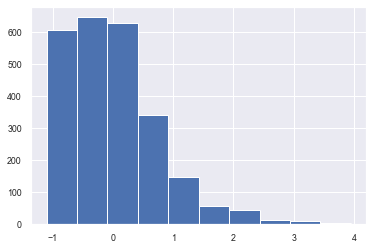

In [45]:
test_df_copy[feature_name].hist();

In [46]:
df[feature_name]=df_copy[feature_name]
test_df[feature_name]=test_df_copy[feature_name]

**Current Credit Balance**

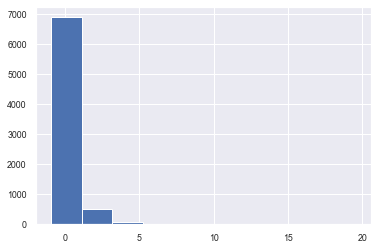

In [47]:
feature_name = 'Current Credit Balance'
df_copy[feature_name].hist();

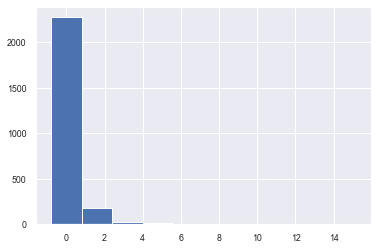

In [48]:
test_df_copy[feature_name].hist();

In [49]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_copy[feature_name].isna().sum()

46

In [50]:
test_df_copy = preprocess_outlier(test_df_copy, feature_name, threshold=5)
test_df_copy[feature_name].isna().sum()

18

In [51]:
pay_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8919152078415831
r2 на test: 0.7067695589013443


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [52]:
pay_amt1_predictor, test_df_copy = imputer_rfr(test_df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9181123852560735
r2 на test: 0.610451830381475


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [53]:
df_copy[feature_name].isna().sum()

0

In [54]:
test_df_copy[feature_name].isna().sum()

0

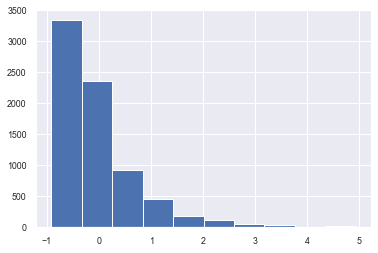

In [55]:
df_copy[feature_name].hist();

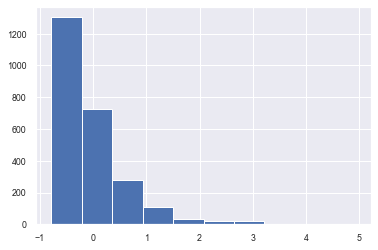

In [56]:
test_df_copy[feature_name].hist();

In [57]:
df[feature_name]=df_copy[feature_name]
test_df[feature_name]=test_df_copy[feature_name]

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [59]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [60]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [61]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
test_df.to_csv(TEST_FULL_PATH, index=False, encoding='utf-8')

train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Загрузка подготовленных датасетов

**Загрузка данных**

In [98]:
df = pd.read_csv(TRAIN_FULL_PATH)
test_df = pd.read_csv(TEST_FULL_PATH)

df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

**Выделение признакового описания и целевой переменной**

In [99]:
X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_test = df_test[TARGET_NAME]

**Балансировка целевой переменной**

In [100]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    3771
0    3771
Name: Credit Default, dtype: int64

In [101]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

## Logistic Regression

In [110]:
model_lr = LogisticRegression(C=0.01,
                              max_iter=10
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_.mean()

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.42      0.53      3771
           1       0.59      0.83      0.69      3771

    accuracy                           0.63      7542
   macro avg       0.65      0.63      0.61      7542
weighted avg       0.65      0.63      0.61      7542

TEST

              precision    recall  f1-score   support

           0       0.84      0.42      0.56      1616
           1       0.35      0.79      0.48       634

    accuracy                           0.52      2250
   macro avg       0.59      0.60      0.52      2250
weighted avg       0.70      0.52      0.54      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               676  940
1               133  501


(array([-0.24741423]), -0.14259261686970653)

In [111]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [120]:
%%time
model_lr_cv = LogisticRegressionCV(max_iter=4,
                                   cv=cv, Cs=[0.01], 
                                   )
model_lr_cv.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.42      0.53      3771
           1       0.59      0.83      0.69      3771

    accuracy                           0.63      7542
   macro avg       0.65      0.63      0.61      7542
weighted avg       0.65      0.63      0.61      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.42      0.56      1616
           1       0.35      0.79      0.48       634

    accuracy                           0.52      2250
   macro avg       0.59      0.60      0.52      2250
weighted avg       0.70      0.52      0.54      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               676  940
1               134  500
Wall time: 127 ms


## Support Vector Machine

In [69]:
%%time
model_svc = SVC(C=0.05,
                kernel='rbf'
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.31      0.45      3771
           1       0.57      0.93      0.71      3771

    accuracy                           0.62      7542
   macro avg       0.69      0.62      0.58      7542
weighted avg       0.69      0.62      0.58      7542

TEST

              precision    recall  f1-score   support

           0       0.88      0.31      0.46      1616
           1       0.34      0.89      0.49       634

    accuracy                           0.47      2250
   macro avg       0.61      0.60      0.47      2250
weighted avg       0.73      0.47      0.47      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               501  1115
1                67   567
Wall time: 15.7 s


In [70]:
%%time
model_svc = SVC(C=0.1,
                kernel='poly',
                degree=3
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.21      0.34      3771
           1       0.56      0.99      0.71      3771

    accuracy                           0.60      7542
   macro avg       0.75      0.60      0.53      7542
weighted avg       0.75      0.60      0.53      7542

TEST

              precision    recall  f1-score   support

           0       0.92      0.21      0.34      1616
           1       0.32      0.95      0.48       634

    accuracy                           0.42      2250
   macro avg       0.62      0.58      0.41      2250
weighted avg       0.75      0.42      0.38      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               334  1282
1                30   604
Wall time: 7.02 s


## XGBoost

In [71]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[12:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.75      0.56      0.64      3771
           1       0.65      0.81      0.72      3771

    accuracy                           0.69      7542
   macro avg       0.70      0.69      0.68      7542
weighted avg       0.70      0.69      0.68      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1616
           1       0.38      0.71      0.50       634

    accuracy                           0.60      2250
   macro avg       0.61      0.63      0.58      2250
weighted avg       0.71      0.60      0.62      2250

CONFUSION MATRIX

col_0

In [72]:
params = {
    'reg_lambda': [0.1, 0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [73]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [74]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

[12:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'reg_lambda': 1.3}

0.7079678439516689

Wall time: 6.89 s


In [75]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=1.3
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[12:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.75      0.55      0.63      3771
           1       0.64      0.81      0.72      3771

    accuracy                           0.68      7542
   macro avg       0.70      0.68      0.68      7542
weighted avg       0.70      0.68      0.68      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.56      0.67      1616
           1       0.39      0.72      0.50       634

    accuracy                           0.60      2250
   macro avg       0.61      0.64      0.58      2250
weighted avg       0.71      0.60      0.62      2250

CONFUSION MATRIX

col_0

### Подбор оптимального размера выборки, кривая обучения

In [76]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

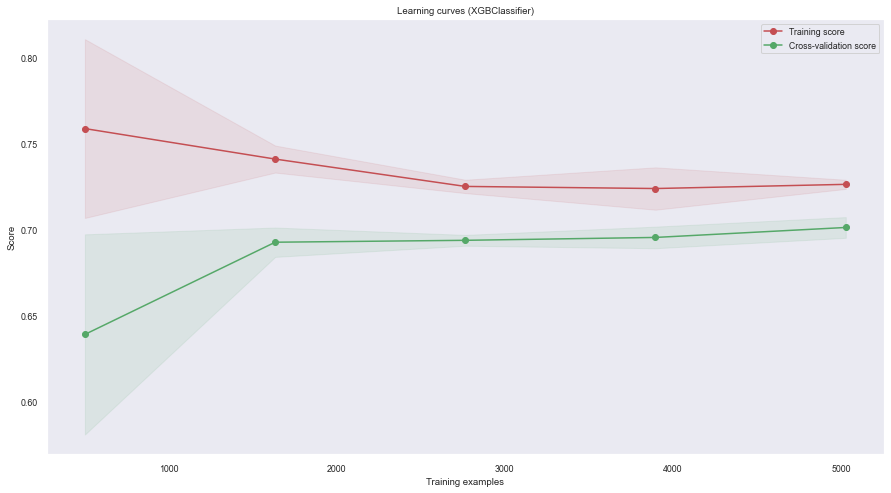

In [77]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

## Catboost

In [78]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train = df_train[BASE_FEATURE_NAMES]
y_train = df_train[TARGET_NAME]

X_test = df_test[BASE_FEATURE_NAMES]
y_test = df_test[TARGET_NAME]

In [79]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [80]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':30
}

In [81]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.52      0.65      3771
           1       0.39      0.76      0.51      1479

    accuracy                           0.59      5250
   macro avg       0.62      0.64      0.58      5250
weighted avg       0.72      0.59      0.61      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.50      0.62      1616
           1       0.36      0.72      0.48       634

    accuracy                           0.56      2250
   macro avg       0.59      0.61      0.55      2250
weighted avg       0.69      0.56      0.58      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               803  813
1               175  459
Wall time: 3.84 s


### Снижение степени переобучения

In [82]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.52      0.65      3771
           1       0.39      0.76      0.51      1479

    accuracy                           0.59      5250
   macro avg       0.62      0.64      0.58      5250
weighted avg       0.72      0.59      0.61      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.50      0.62      1616
           1       0.36      0.72      0.48       634

    accuracy                           0.56      2250
   macro avg       0.59      0.61      0.55      2250
weighted avg       0.69      0.56      0.58      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               803  813
1               175  459


In [83]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [84]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

In [85]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [86]:
grid_search = model.randomized_search(params,
                                      X_train,
                                      y_train,
                                      n_iter=50,
                                      cv=cv,
                                      stratified=True,
                                      plot=True,
                                      refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6368432899
bestIteration = 2

0:	loss: 0.6368433	best: 0.6368433 (0)	total: 1.12s	remaining: 55.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6206637054
bestIteration = 1

1:	loss: 0.6206637	best: 0.6368433 (0)	total: 2.16s	remaining: 51.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6410504137
bestIteration = 4

2:	loss: 0.6410504	best: 0.6410504 (2)	total: 3.36s	remaining: 52.7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6320447711
bestIteration = 4

3:	loss: 0.6320448	best: 0.6410504 (2)	total: 4.47s	remaining: 51.4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6381453695
bestIteration = 4

4:	loss: 0.6381454	best: 0.6410504 (2)	total: 5.53s	remaining: 49.8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6342546407
bestIteration = 3

5:	loss: 0.6342546	best: 0.6410504 (2)	total: 6.52s	remaining: 47.8

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6368432899
bestIteration = 2

49:	loss: 0.6368433	best: 0.6428303 (10)	total: 52s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (30 iterations wait)


In [87]:
grid_search

{'params': {'l2_leaf_reg': 0.840506329113924},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30],
              'test-F1-mean': [0.6422105205321808,
               0.6285200494332924,
               0.6258485766616433,
               0.6126438331622669,
               0.6310622645237207,
               0.6288531660986396,
               0.6382591702040359,
               0.6364968168442499,
               0.6317056793111

In [88]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      3771
           1       0.53      0.80      0.63      1479

    accuracy                           0.74      5250
   macro avg       0.71      0.76      0.72      5250
weighted avg       0.80      0.74      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.64      0.72      1616
           1       0.40      0.61      0.48       634

    accuracy                           0.63      2250
   macro avg       0.61      0.63      0.60      2250
weighted avg       0.69      0.63      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1041  575
1                247  387
Wall time: 102 ms


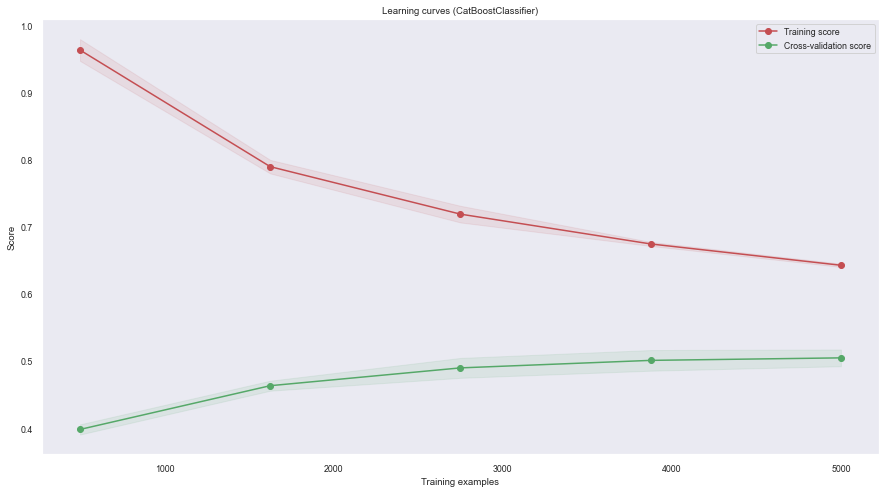

In [89]:
show_learning_curve_plot(model, X, y)

### Важность признаков

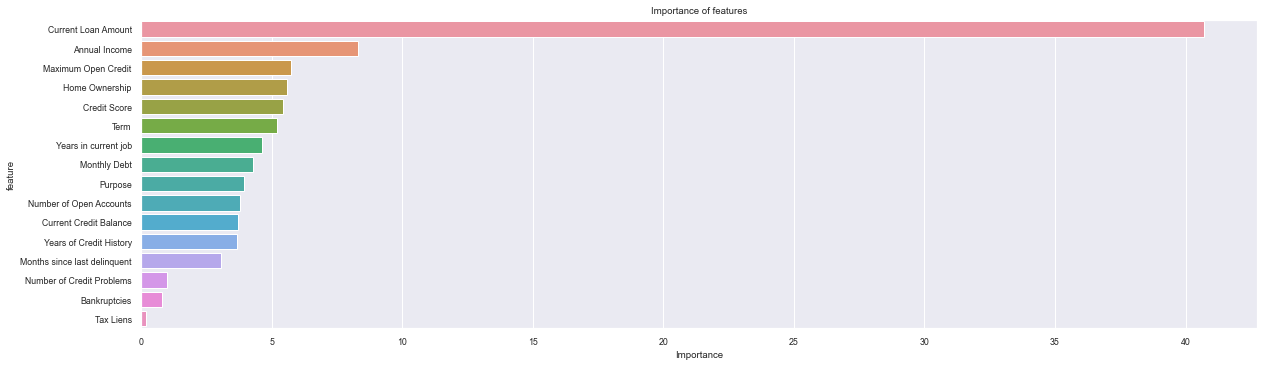

In [90]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

In [91]:
important_features_top

['Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Home Ownership',
 'Credit Score',
 'Term',
 'Years in current job',
 'Monthly Debt',
 'Purpose',
 'Number of Open Accounts',
 'Current Credit Balance',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Credit Problems',
 'Bankruptcies',
 'Tax Liens']

### Финальная модель

In [92]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [93]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Years in current job', 'Purpose', 'Home Ownership', 'Term']

In [94]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=7,
                                      reg_lambda=0.84)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      3771
           1       0.53      0.81      0.64      1479

    accuracy                           0.74      5250
   macro avg       0.72      0.76      0.72      5250
weighted avg       0.80      0.74      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1616
           1       0.40      0.63      0.49       634

    accuracy                           0.63      2250
   macro avg       0.61      0.63      0.60      2250
weighted avg       0.70      0.63      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1022  594
1                234  400
Wall time: 10.7 s


### Сохранение финальной модели

In [95]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Предсказание

In [96]:
predictions = final_model.predict(test_df[important_features_top])

submit = pd.read_csv(PREDICTION_PATH)
submit['Credit Default'] = predictions
submit.to_csv(PREDICTION_PATH, index=False)

submit

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,0
